This is a tutorial for applying N2N4M to individual pixels/a subset of an image rather than the entire image. This is a more involved process than applying it across an image.

In [1]:
# Standard Imports
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import os
import torch
import urllib.request
import importlib.resources

# Imports from this project
from n2n4m.crism_image import CRISMImage
from n2n4m.plot import Visualiser
from n2n4m.preprocessing import impute_bad_values_in_image
from n2n4m.model import Noise2Noise1D
from n2n4m.model_functions import check_available_device, predict
from n2n4m.n2n4m_denoise import create_dataloader, load_scaler, instantiate_default_model, clip_bands, combine_bands
from n2n4m.wavelengths import ALL_WAVELENGTHS

In [2]:
DEFAULT_MODEL_FILEPATH = (
    importlib.resources.files("n2n4m") / "data/trained_model_weights.pt"
)
DEFAULT_SCALER_FILEPATH = (
    importlib.resources.files("n2n4m") / "data/n2n4m_feature_scaler.joblib"
)

In [3]:
# Instantiate the CRISMImageN2N4M object
DATA_DIR = "/home/rob_platt/N2N4M/N2N4M/data" # Please insert the path to the directory where you are storing the image e.g. "user/data/"
IMAGE_PATH = os.path.join(DATA_DIR, "example_image", "ATU0003561F_01_IF168L_TRR3.img") # Change this to the name of whichever image you want to use
example_image = CRISMImage(IMAGE_PATH)

Let us say we are only interested in denoising the region highlighted in red in the image below.

/home/rob_platt/n2n4m/n2n4m/plot.py:105: UserWarning: Bad values detected in the image. A copy has been made, values > 1000 will be replaced with np.nan.
  warnings.warn(


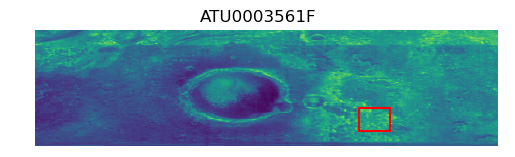

In [5]:
vis = Visualiser(example_image)

fig, ax = plt.subplots()
vis.plot_image(vis.get_image(60), ax=ax)

# Highlighted area for visualisation
rect = patches.Rectangle((450, 100), 40, 30, linewidth=1.5, edgecolor='r', facecolor='none')
ax.add_patch(rect)

In [6]:
# Load the fitted ML model and feature scaler
feature_scaler = load_scaler(DEFAULT_SCALER_FILEPATH)
model = instantiate_default_model(DEFAULT_MODEL_FILEPATH)

In [7]:
spectra = example_image.image_array
# Extract the spectra from the highlighted area (y, x, wavelength).
# This could be done using a mask, or just pick an individual pixel.
spectra_of_interest = spectra[100:130, 450:490, :] 
# Reshape the spectra to be 2D (n_samples, wavelengths)
spectra_of_interest = spectra_of_interest.reshape(-1, spectra_of_interest.shape[-1]) 
# Split the bands the model was trained to denoise from the additional bands
bands_to_denoise, additional_bands = clip_bands(spectra=spectra_of_interest)
# Impute any bad values in the bands to denoise
bands_to_denoise, bad_value_mask = impute_bad_values_in_image(bands_to_denoise)

In [8]:
# Apply feature scaling
bands_to_denoise = feature_scaler.transform(bands_to_denoise)
# Create dataloader of the data 
dataloader = create_dataloader(bands_to_denoise, batch_size=64)
# Run denoising
denoised_spectra = predict(model, dataloader, device=check_available_device())

/home/rob_platt/miniforge3/envs/N2N4M/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(


In [9]:
# Detach tensor from any device and convert to numpy array
denoised_spectra.cpu().numpy()

array([[0.18594676, 0.18124215, 0.1824867 , ..., 0.11672254, 0.12032858,
        0.12194197],
       [0.18799919, 0.18335885, 0.18470924, ..., 0.1174162 , 0.12093802,
        0.12257691],
       [0.18363981, 0.1790517 , 0.18029034, ..., 0.12048453, 0.12398425,
        0.1256039 ],
       ...,
       [0.17954724, 0.1753471 , 0.1762731 , ..., 0.11989269, 0.1235239 ,
        0.12501916],
       [0.17694391, 0.17285529, 0.17390366, ..., 0.12132341, 0.1247256 ,
        0.12616743],
       [0.17573218, 0.1717383 , 0.17277525, ..., 0.11532082, 0.11872421,
        0.12014381]], dtype=float32)

In [10]:
# re-insert all the bad values back into the denoised spectra
# this is optional, but if working pixel by pixel to identify mineralogy of interest is highly recommended.
denoised_spectra[bad_value_mask] = 65535

In [11]:
# Recombine the denoised bands with the additional bands
denoised_spectra = combine_bands(denoised_spectra, additional_bands)
# Now have an array of the denoised spectra to do with as you wish.
denoised_spectra.shape

(1200, 438)